# Setup

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree, DecisionTreeClassifier
from sklearn import metrics

# TODo remove when package is updated
import sys,os
sys.path.append(os.path.expanduser('~/imodels'))

# installable with: `pip install imodels`
from imodels import FIGSClassifier
import demo_helper
np.random.seed(13)

Let's start by loading some data in...  
Note, we need to still load the reg dataset first to get the same splits as in `imodels_demo.ipynb` due to the call to random

In [2]:
# ames housing dataset: https://www.openml.org/search?type=data&status=active&id=43926
X_train_reg, X_test_reg, y_train_reg, y_test_reg, feat_names_reg = demo_helper.get_ames_data()

# diabetes dataset: https://www.openml.org/search?type=data&sort=runs&id=37&status=active
X_train, X_test, y_train, y_test, feat_names = demo_helper.get_diabetes_data()
    # feat_names meanings:
    # ["#Pregnant", "Glucose concentration test", "Blood pressure(mmHg)",
    # "Triceps skin fold thickness(mm)",
    # "2-Hour serum insulin (mu U/ml)", "Body mass index", "Diabetes pedigree function", "Age (years)"]

# load some data
# print('Regression data training', X_train_reg.shape, 'Classification data training', X_train.shape)

***
# FIGS

In [3]:
model_figs = FIGSClassifier(max_rules=7, max_trees=3)

In [4]:
model_figs.fit(X_train, y_train, feature_names=feat_names);

In [5]:
print(model_figs)

> ------------------------------
> FIGS-Fast Interpretable Greedy-Tree Sums:
> 	Predictions are made by summing the "Val" reached by traversing each tree.
> 	For classifiers, a sigmoid function is then applied to the sum.
> ------------------------------
Glucose concentration test <= 99.500 (Tree #0 root)
	Val: 0.068 (leaf)
	Glucose concentration test <= 168.500 (split)
		#Pregnant <= 6.500 (split)
			Body mass index <= 30.850 (split)
				Val: 0.065 (leaf)
				Blood pressure(mmHg) <= 67.000 (split)
					Val: 0.705 (leaf)
					Val: 0.303 (leaf)
			Val: 0.639 (leaf)
		Blood pressure(mmHg) <= 93.000 (split)
			Val: 0.860 (leaf)
			Val: -0.009 (leaf)

	+
Diabetes pedigree function <= 0.404 (Tree #1 root)
	Val: -0.088 (leaf)
	Val: 0.106 (leaf)



In [6]:
print(model_figs.print_tree(X_train, y_train))

------------
Glucose concentration test <= 99.500 65/192 (33.85%)
	ΔRisk = 0.07 4/59 (6.78%)
	Glucose concentration test <= 168.500 61/133 (45.86%)
		#Pregnant <= 6.500 44/112 (39.29%)
			Body mass index <= 30.850 21/76 (27.63%)
				ΔRisk = 0.06 2/31 (6.45%)
				Blood pressure(mmHg) <= 67.000 19/45 (42.22%)
					ΔRisk = 0.71 10/14 (71.43%)
					ΔRisk = 0.30 9/31 (29.03%)
			ΔRisk = 0.64 23/36 (63.89%)
		Blood pressure(mmHg) <= 93.000 17/21 (80.95%)
			ΔRisk = 0.86 17/19 (89.47%)
			ΔRisk = -0.01 0/2 (0.0%)

	+
Diabetes pedigree function <= 0.404 65/192 (33.85%)
	ΔRisk = -0.09 25/105 (23.81%)
	ΔRisk = 0.11 40/87 (45.98%)



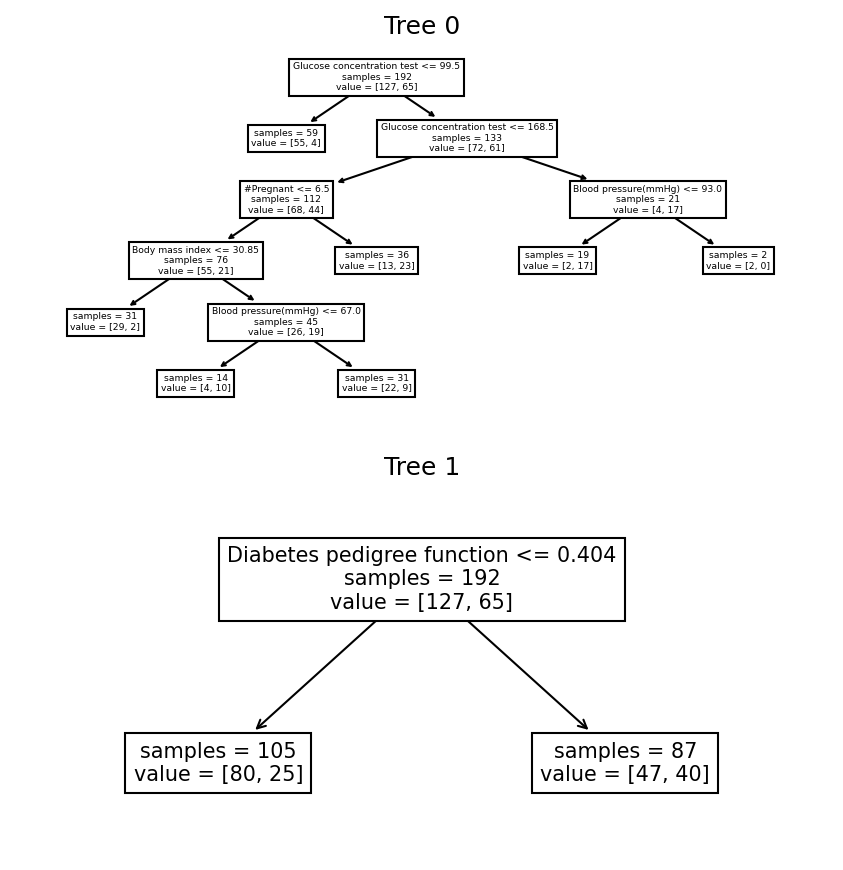

In [7]:
model_figs.plot(fig_size=7)

## Gini Importance

In [8]:
dfp_importance = pd.DataFrame({'feat_names': feat_names})
dfp_importance['feature'] = dfp_importance.index
dfp_importance_gini = pd.DataFrame({'importance_gini': model_figs.feature_importances_})
dfp_importance_gini['feature'] = dfp_importance_gini.index
dfp_importance_gini['importance_gini_pct'] = dfp_importance_gini['importance_gini'].rank(pct=True)
dfp_importance = pd.merge(dfp_importance, dfp_importance_gini, on='feature', how='left')
dfp_importance = dfp_importance.sort_values(by=['importance_gini', 'feature'], ascending=[False, True]).reset_index(drop=True)
display(dfp_importance)

,feat_names,feature,importance_gini,importance_gini_pct
0,Diabetes pedigree function,6,0.421422,1.000
1,Glucose concentration test,1,0.275414,0.875
2,#Pregnant,0,0.123990,0.750
3,Body mass index,5,0.092911,0.625
4,Blood pressure(mmHg),2,0.086263,0.500
5,Triceps skin fold thickness(mm),3,0.000000,0.250
6,2-Hour serum insulin (mu U/ml),4,0.000000,0.250
7,Age (years),7,0.000000,0.250


***
# `dtreeviz` Integration
One tree at a time only, showing tree 0 here

In [9]:
import dtreeviz
from imodels.tree.viz_utils import extract_sklearn_tree_from_figs

dt = extract_sklearn_tree_from_figs(model_figs, tree_num=0, n_classes=2)
viz_model = dtreeviz.model(dt, X_train=X_train, y_train=y_train, feature_names=feat_names, target_name='y', class_names=[0, 1])

In [10]:
# color_params = {'classes': mpl_colors, 'hist_bar': 'C0', 'legend_edge': None} # TODO
color_params = {'hist_bar': 'C0', 'legend_edge': None}
for _ in ['axis_label', 'title', 'legend_title', 'text', 'arrow', 'node_label', 'tick_label', 'leaf_label', 'wedge', 'text_wedge']:
    color_params[_] = 'black'
dtv_params_gen = {'colors': color_params, 'fontname': 'Arial', 'figsize': (4, 3)}
dtv_params = {#'leaftype': 'barh', # TODO
              'label_fontsize': 10,
              'colors': dtv_params_gen['colors'],
              'fontname': dtv_params_gen['fontname']
             }

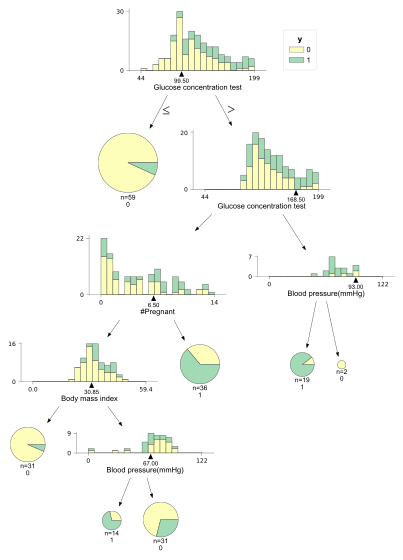

In [11]:
viz_model.view(**dtv_params)

In [12]:
x_example = X_train[13]
display(pd.DataFrame([{col: value for col,value in zip(feat_names, x_example)}]))

,#Pregnant,Glucose concentration test,Blood pressure(mmHg),Triceps skin fold thickness(mm),2-Hour serum insulin (mu U/ml),Body mass index,Diabetes pedigree function,Age (years)
0,0.0,131.0,88.0,0.0,0.0,31.6,0.743,32.0


In [13]:
print(viz_model.explain_prediction_path(x=x_example))

#Pregnant < 6.5
99.5 <= Glucose concentration test  < 168.5
67.0 <= Blood pressure(mmHg) 
30.85 <= Body mass index 



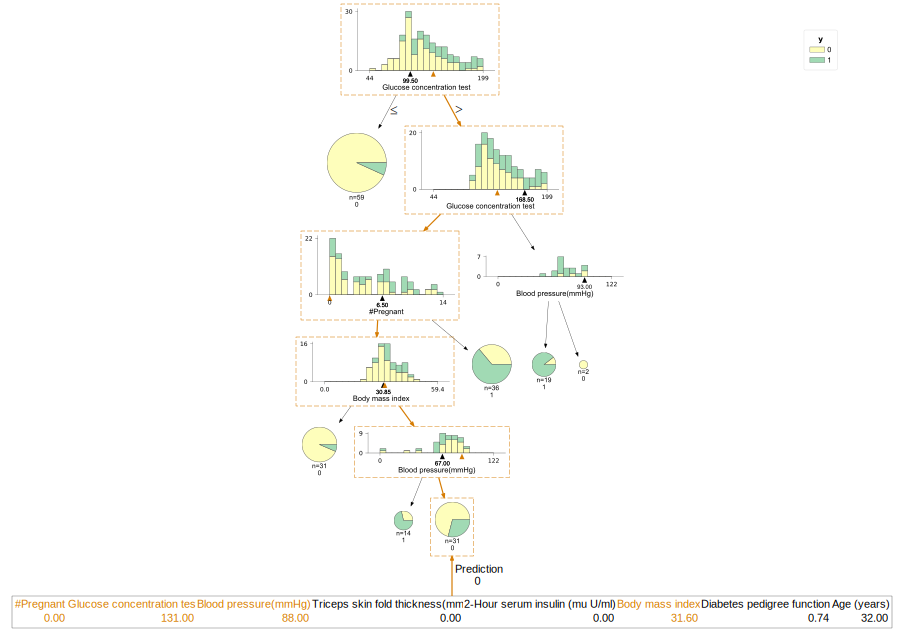

In [14]:
viz_model.view(**dtv_params, x=x_example)

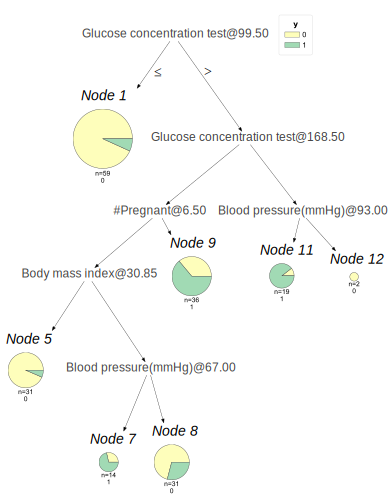

In [15]:
viz_model.view(**dtv_params, show_node_labels=True, fancy=False)

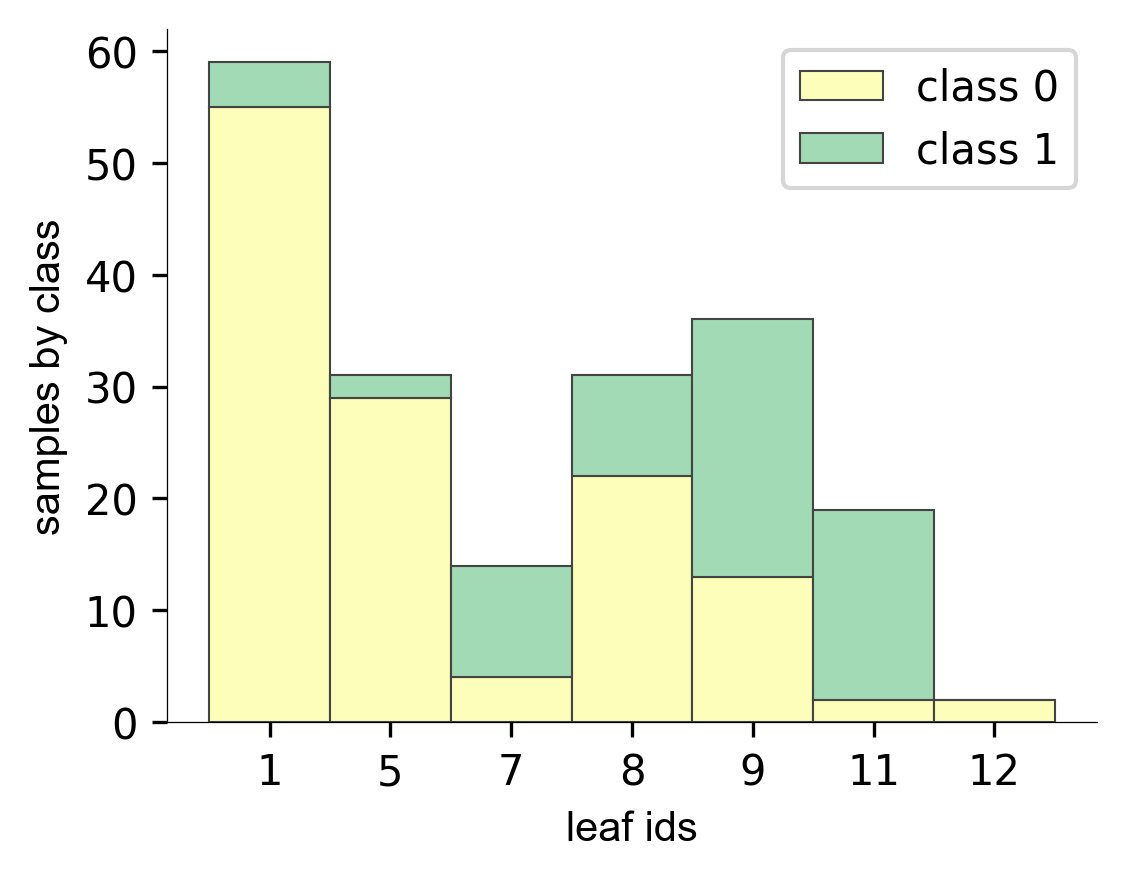

In [16]:
viz_model.ctree_leaf_distributions(**dtv_params_gen)

/home/mepland/.venvs/imodels/lib64/python3.11/site-packages/dtreeviz/trees.py:731: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.


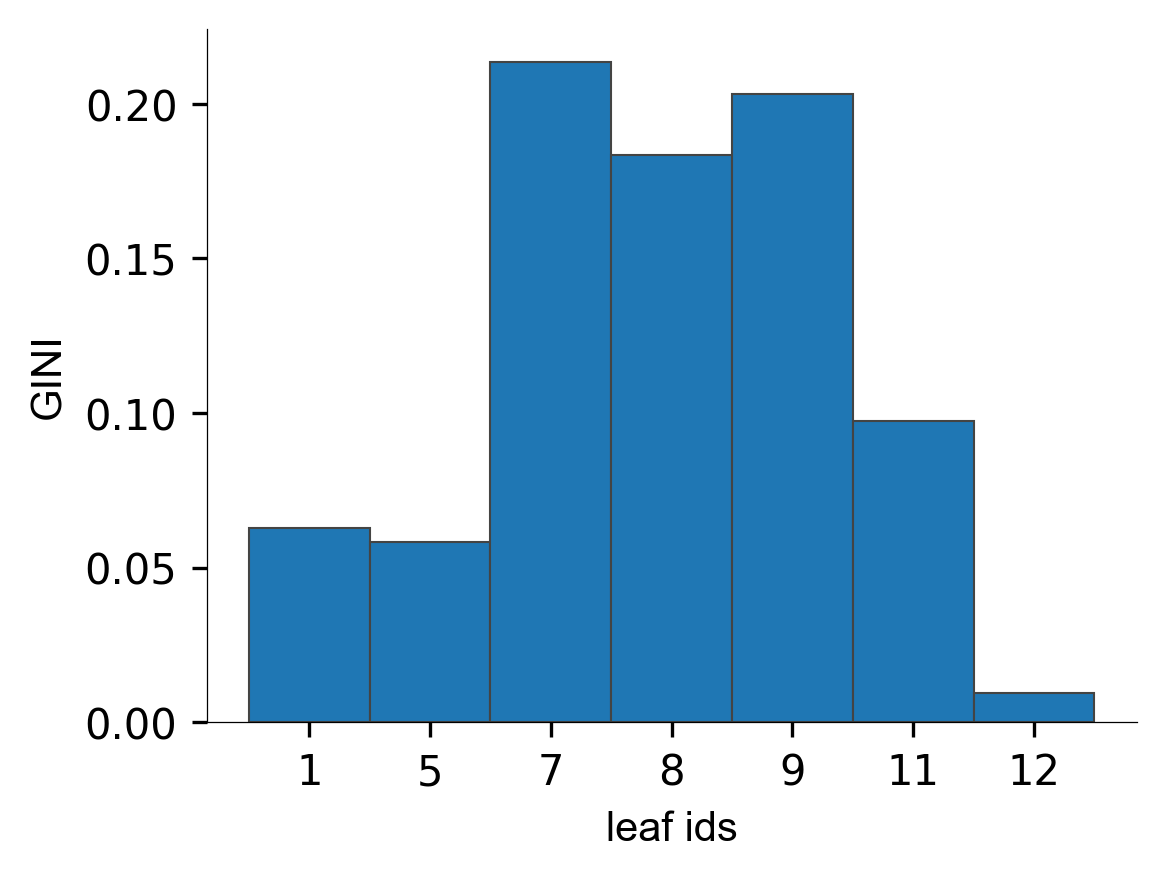

In [17]:
viz_model.leaf_purity(display_type='plot', **dtv_params_gen)

***
# `SKompiler` Integration
One tree at a time only, showing tree 0 here

In [18]:
from skompiler import skompile
from imodels.tree.viz_utils import extract_sklearn_tree_from_figs

dt = extract_sklearn_tree_from_figs(model_figs, tree_num=0, n_classes=2)
expr = skompile(dt.predict_proba, feat_names)

In [19]:
print(expr.to('sqlalchemy/sqlite', component=1, assign_to='tree_0'))

SELECT CASE WHEN ("Glucose concentration test" <= 99.5) THEN 0.06779661016949153 ELSE CASE WHEN ("Glucose concentration test" <= 168.5) THEN CASE WHEN ("#Pregnant" <= 6.5) THEN CASE WHEN ("Body mass index" <= 30.84999942779541) THEN 0.06451612903225806 ELSE CASE WHEN ("Blood pressure(mmHg)" <= 67.0) THEN 0.7142857142857143 ELSE 0.2903225806451613 END END ELSE 0.6388888888888888 END ELSE CASE WHEN ("Blood pressure(mmHg)" <= 93.0) THEN 0.8947368421052632 ELSE 0.0 END END END AS tree_0 
FROM data


In [20]:
print(expr.to('python/code'))

(np.array([0.9322033898305084, 0.06779661016949153]) if 
    Glucose concentration test <= 99.5 else ((np.array([
    0.9354838709677419, 0.06451612903225806]) if Body mass index <= 
    30.84999942779541 else np.array([0.2857142857142857, 
    0.7142857142857143]) if Blood pressure(mmHg) <= 67.0 else np.array(
    [0.7096774193548387, 0.2903225806451613])) if #Pregnant <= 6.5 else
    np.array([0.3611111111111111, 0.6388888888888888])) if 
    Glucose concentration test <= 168.5 else np.array([
    0.10526315789473684, 0.8947368421052632]) if Blood pressure(mmHg) <= 
    93.0 else np.array([1.0, 0.0]))

